In [4]:
from fastbook import *

In [5]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls), urls[0]

(1,
 'https://fthmb.tqn.com/tvPe1GjuUCasntTK2maHH_0FBZo=/1280x853/filters:fill(auto,1)/gouldian-finch-188062467-resized-58a6ea6e5f9b58a3c9190af4.jpg')

In [6]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=True)

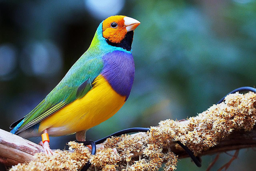

In [7]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [14]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200], max_pics=200)
        resize_images(dest, max_size=400, dest=dest)


In [15]:
failed = verify_images(get_image_files(path))
failed .map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None,None,None]

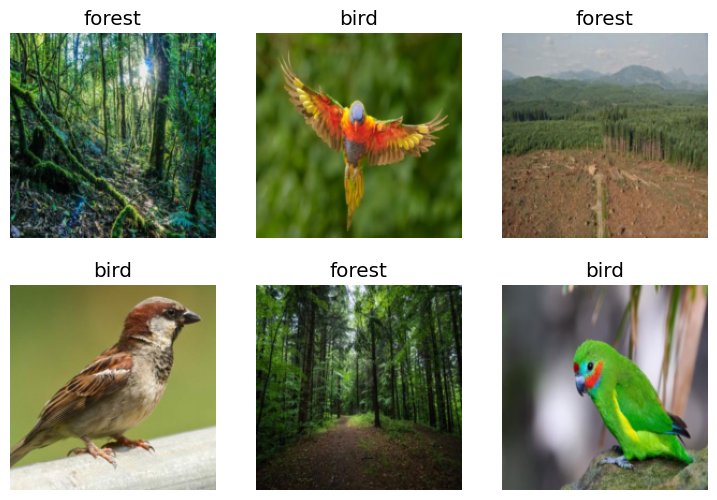

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/juliankmazo/Developer/personal/ai-engineering-learning/.venv/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/juliankmazo/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:22<00:00, 2.09MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.790874,0.383242,0.085714,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.135074,0.157170,0.057143,00:02
1,0.084616,0.110502,0.042857,00:01
2,0.060948,0.090337,0.028571,00:01


In [18]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
